In [252]:
import numpy as np
import pandas as pd
import os.path, matplotlib
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
import pickle
import time

In [2]:
def preprocess_data(data, center=True):
    '''
    centers and splits the data for testing and training
    returns x_train, x_test, y_train, y_test
    '''
    label = data.label
    df = data.drop(['label','filename'], axis=1)
    if center:
        scaler = StandardScaler()
        scaler.fit(df)
        df = scaler.transform(df)
    return train_test_split(df, label, test_size=0.5)

In [3]:
def gridsearch(classifier, params, x_train, y_train, name="Test_"):
    '''
    Uses GridSearchCV to tune hyperparameters and saves the GridSearchCV results
    Trains the classifier with the best parameters and scores the model
    '''
    start_time = time.time()
    clf = GridSearchCV(classifier, params, n_jobs=-1, cv=10)
    grid = clf.fit(x_train, y_train)
    print("GridSearchCV elapsed time: {}".format(time.time() - start_time))

    # best_params = grid.best_params_
    # best_score = grid.best_score_
    # print("{}GridSearch \nBest params: {} \nScore: {}".format(name, best_params, best_score))
    
    # Saves GridSearch Result
    filename = "{}GridSearch.sav".format(name)
    pickle.dump(grid, open(filename, 'wb'))
    return grid

In [107]:
def rfc(data, center=True):
    '''
    Uses GridSearchCV to tune hyperparameters for RandomForestClassification
    Saves the grid results to a pickle
    '''
    x_train, x_test, y_train, y_test = preprocess_data(data)
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
    max_depth = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
    max_features = ['sqrt','log2', None]
    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }
    grid = gridsearch(RandomForestClassifier(), params, x_train, y_train, name="RandomForest_")
    return grid, x_train, x_test, y_train, y_test

In [5]:
data = pd.read_csv('data/data.csv')

In [ ]:
rfc_grid = rfc(data)

In [6]:
def non_linear_svm(data, center=True):
    x_train, x_test, y_train, y_test = preprocess_data(data)
    C = np.logspace(-2, 4, 7)
    gamma = np.logspace(-3, 3, 7)
    kernel = ['poly', 'rbf', 'sigmoid']
    params = {
        'C': C,
        'gamma': gamma,
        'kernel': kernel,
    }
    grid = gridsearch(SVC(), params, x_train, y_train, name="NonLinearSVC_")
    return grid, x_train, x_test, y_train, y_test

In [190]:
svm_grid, x_train, x_test, y_train, y_test = non_linear_svm(data)
svm_res = svm_grid.cv_results_

GridSearchCV elapsed time: 6.018208980560303


In [215]:
rfc_grid = pickle.load(open('RandomForest0_GridSearch.sav', 'rb'))
svm_grid = pickle.load(open('NonLinearSVC0_GridSearch.sav', 'rb'))
rfc_res = rfc_grid.cv_results_
svm_res = svm_grid.cv_results_

In [216]:
svm_grid.best_estimator_

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [217]:
svm_clf = svm_grid.best_estimator_
scores = cross_val_score(svm_clf, x_test, y_test, cv=10)

In [218]:
# 9 degrees of freedome 95% two tailed CI
t = 2.262
mean = np.mean(scores)
se = np.std(scores)/10
ci = [mean - (t*se), mean + (t*se)]

In [219]:
print("95% Confidence Interval: [{}, {}]".format(ci[0], ci[1]))

95% Confidence Interval: [0.6221401696402514, 0.6538598303597484]


In [96]:
np.concatenate((scores, scores))

array([0.58, 0.62, 0.62, 0.64, 0.64, 0.42, 0.76, 0.6 , 0.5 , 0.56, 0.58,
       0.62, 0.62, 0.64, 0.64, 0.42, 0.76, 0.6 , 0.5 , 0.56])

In [100]:
len(scores)

10

In [102]:
def get_ci(scores):
    '''
    19 degrees of freedome 95% two tailed CI
    '''
    t = 2.093
    mean = np.mean(scores)
    se = np.std(scores)/len(scores)
    ci = [mean - (t*se), mean + (t*se)]
    print("95% Confidence Interval: [{}, {}]".format(ci[0], ci[1]))

In [275]:
grid0 = pickle.load(open('RandomForest0_GridSearch.sav', 'rb'))
res0 = grid0.cv_results_
grid1 = pickle.load(open('RandomForest0_GridSearch.sav', 'rb'))
res1 = grid1.cv_results_

In [276]:
print(grid0.best_params_)
print(grid1.best_params_)

{'max_depth': 300, 'max_features': 'sqrt', 'n_estimators': 500}
{'max_depth': 300, 'max_features': 'sqrt', 'n_estimators': 500}


In [282]:
grid0 = pickle.load(open('NonLinearSVC0_GridSearch.sav', 'rb'))
res0 = grid0.cv_results_
grid1 = pickle.load(open('NonLinearSVC1_GridSearch.sav', 'rb'))
res1 = grid1.cv_results_

In [283]:
res0.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [284]:
res0['params']

[{'C': 0.01, 'gamma': 0.001, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'},
 {'C': 0.01, 'gamma': 0.01, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'},
 {'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 0.1, 'kernel': 'sigmoid'},
 {'C': 0.01, 'gamma': 1.0, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 1.0, 'kernel': 'sigmoid'},
 {'C': 0.01, 'gamma': 10.0, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 10.0, 'kernel': 'sigmoid'},
 {'C': 0.01, 'gamma': 100.0, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 100.0, 'kernel': 'sigmoid'},
 {'C': 0.01, 'gamma': 1000.0, 'kernel': 'poly'},
 {'C': 0.01, 'gamma': 1000.0, 'kernel': 'rbf'},
 {'C': 0.01, 'gamma': 1000.0, 'kernel': 'sigm

In [409]:
# X-axis is max_depth. Y-axis is mean score. Color is max_features setting.
redx = []
redy = []
greenx = []
greeny = []
bluex = []
bluey = []
y = res0['mean_test_score']
x = [param['gamma'] for param in res0['params']]
i = 0
for param in res0['params']:
    if param['kernel'] == 'poly':
        redx.append(x[i])
        redy.append(y[i])
    if param['kernel'] == 'rbf':
        greenx.append(x[i])
        greeny.append(y[i])
    if param['kernel'] == 'sigmoid':
        bluex.append(x[i])
        bluey.append(y[i])
    i+=1

In [413]:
np.unique(np.array(x))

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [408]:
np.concatenate((redx, redy),axis=0)
reds = np.concatenate((np.reshape(redx, (len(redx),1)), np.reshape(redy, (len(redy),1))), axis=1)

In [371]:
reds[:,0]

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])

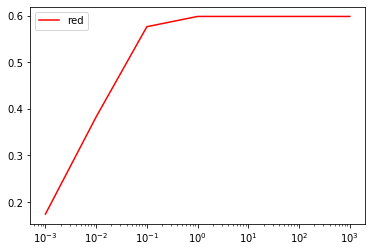

In [403]:
redline = []
for gam in np.logspace(-3, 3, 7):
    targets = np.where(reds[:,0] == gam)
    #np.concatenate(np.array, [gam, np.average(reds[targets,1])])
    redline.append([gam, np.average(reds[targets,1])])
redline = np.array(redline)
plt.semilogx(redline[:,0], redline[:,1], label="red", color="red")
plt.legend()
plt.show()

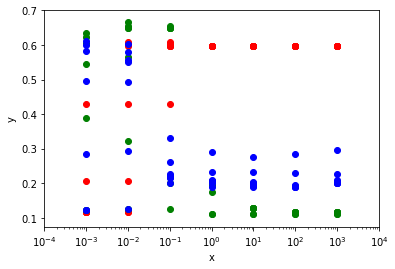

In [354]:
plt.clf()
plt.scatter(redx,redy,color='red')
plt.scatter(greenx,greeny,color='green')
plt.scatter(bluex,bluey,color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0.0001, 10000)
plt.xscale('log')
plt.show()

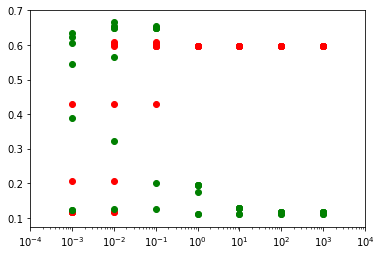

In [329]:
plt.scatter(redx,redy,color='red')
plt.scatter(greenx,greeny,color='green')
plt.xlim(0.0001, 10000)
plt.xscale('log')
plt.show()

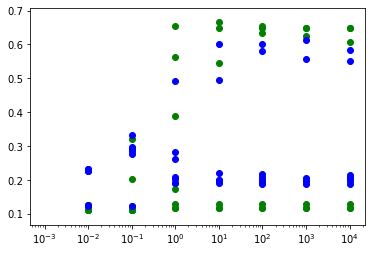

In [291]:
plt.scatter(greenx,greeny,color='green')
plt.scatter(bluex,bluey,color='blue')
plt.xscale('log')
plt.show()

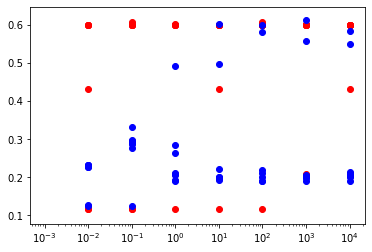

In [290]:
plt.scatter(redx,redy,color='red')
plt.scatter(bluex,bluey,color='blue')
plt.xscale('log')
plt.show()

In [401]:
def make_line(x,y,xvals):
    xy = np.concatenate((np.reshape(x, (len(x),1)), np.reshape(y, (len(y),1))), axis=1)
    line = []
    for gam in xvals:
        targets = np.where(xy[:,0] == gam)
        line.append([gam, np.average(xy[targets,1])])
    return np.array(line)

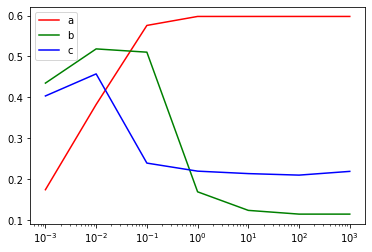

In [406]:
redline = make_line(redx, redy, np.logspace(-3, 3, 7))
greenline = make_line(greenx, greeny, np.logspace(-3, 3, 7))
blueline = make_line(bluex, bluey, np.logspace(-3, 3, 7))
plt.semilogx(redline[:,0], redline[:,1], label=str('a'), color="red")
plt.semilogx(greenline[:,0], greenline[:,1], label=str('b'), color="green")
plt.semilogx(blueline[:,0], blueline[:,1], label=str('c'), color="blue")
plt.legend()

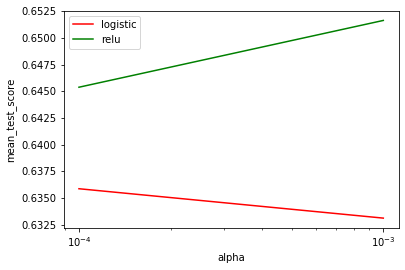

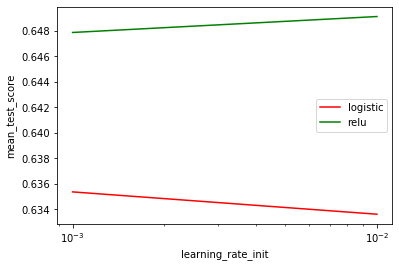

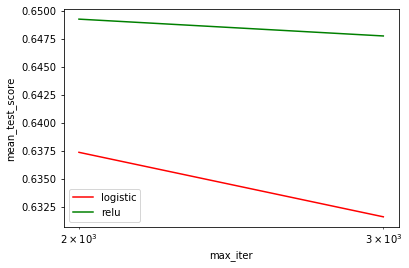

In [427]:
grid0 = pickle.load(open('MLP0_GridSearch.sav', 'rb'))
res0 = grid0.cv_results_
grid1 = pickle.load(open('MLP1_GridSearch.sav', 'rb'))
res1 = grid1.cv_results_
y = res0['mean_test_score']
x = [param['alpha'] for param in res0['params']]
get_nn_graphs(x,y, res0['params'], 'logistic', 'relu', "plots/SVM_C", "alpha")
x = [param['learning_rate_init'] for param in res0['params']]
get_nn_graphs(x,y, res0['params'], 'logistic', 'relu', "plots/SVM_C", "learning_rate_init")
x = [param['max_iter'] for param in res0['params']]
get_nn_graphs(x,y, res0['params'], 'logistic', 'relu', "plots/SVM_C", "max_iter")


In [433]:
print("Best Param 1: {}".format(grid0.best_params_))

Best Param 1: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200, 200, 200), 'learning_rate_init': 0.01, 'max_iter': 2000}


In [434]:
print("Best Param 2: {}".format(grid1.best_params_))

Best Param 2: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 200), 'learning_rate_init': 0.001, 'max_iter': 3000}


In [ ]:
{'hidden_layer_sizes': [(100, 100, 100), (200, 200, 200), (100, 100), (200, 200)], 'activation': ['logistic', 'relu'], 'alpha': [0.0001, 0.001], 'learning_rate_init': [0.01, 0.001], 'max_iter': [2000, 3000]}

In [430]:
def nn_graphs():
    grid0 = pickle.load(open('MLP0_GridSearch.sav', 'rb'))
    res0 = grid0.cv_results_
    grid1 = pickle.load(open('MLP1_GridSearch.sav', 'rb'))
    res1 = grid1.cv_results_
    y = res0['mean_test_score']
    x = [param['alpha'] for param in res0['params']]
    get_nn_graphs(x,y, res0['params'], 'logistic', 'relu', "plots/SVM_C", "alpha")
    x = [param['learning_rate_init'] for param in res0['params']]
    get_nn_graphs(x,y, res0['params'], 'logistic', 'relu', "plots/SVM_C", "learning_rate_init")
    x = [param['max_iter'] for param in res0['params']]
    get_nn_graphs(x,y, res0['params'], 'logistic', 'relu', "plots/SVM_C", "max_iter")

def get_nn_graphs(x, y, params, c1, c2, name, xname, yname='mean_test_score', weirdx=False):
    redx = []
    redy = []
    greenx = []
    greeny = []
    bluex = []
    bluey = []
    i = 0
    for param in params:
        if param['activation'] == c1:
            if weirdx:
                redx.append(x[i][0])
            else:
                redx.append(x[i])
            redy.append(y[i])
        if param['activation'] == c2:
            if weirdx:
                greenx.append(x[i][0])
            else:
                greenx.append(x[i])
            greeny.append(y[i])
        i+=1
#     plt.scatter(redx,redy,color='red',label=c1)
#     plt.scatter(greenx,greeny,color='green',label=c2)
#     plt.legend()
#     plt.xlabel(xname)
#     plt.ylabel(yname)
#     plt.show()
#     plt.clf()
    
#     plt.scatter(redx,redy,color='red',label=c1)
#     plt.scatter(greenx,greeny,color='green',label=c2)
#     plt.legend()
#     plt.xlabel(xname)
#     plt.ylabel(yname)
#     plt.xscale('log')
#     plt.show()
#     plt.clf()

    uniquex = np.unique(np.array(x))

    redline = make_line(redx, redy, uniquex)
    greenline = make_line(greenx, greeny, uniquex)
#     blueline = make_line(bluex, bluey, uniquex)
    plt.semilogx(redline[:,0], redline[:,1], label=str(c1), color="red")
    plt.semilogx(greenline[:,0], greenline[:,1], label=str(c2), color="green")
#     plt.semilogx(blueline[:,0], blueline[:,1], label=str(c3), color="blue")
    plt.legend()
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.show()
#     plt.savefig('{}_line.png'.format(name))
#     plt.clf()

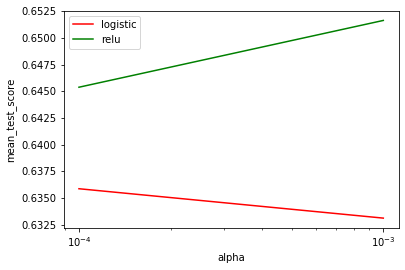

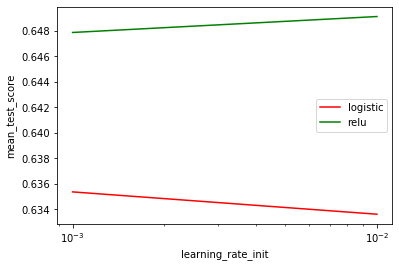

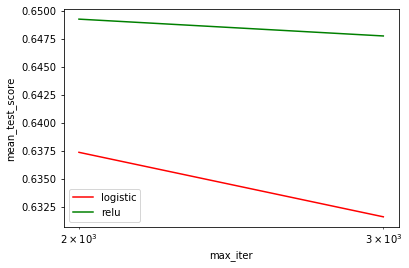

In [431]:
nn_graphs()

In [442]:
[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

[0.0001,
 0.02008,
 0.040060000000000005,
 0.06004000000000001,
 0.08002000000000001,
 0.1]